In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


The csv file used is available here: https://github.com/nijdarshan/democratizing-ai-kannada/tree/main/code/csvs

In [ ]:
# ================================
# Install libs
# ================================
!pip install -q sentence-transformers transformers torch umap-learn scikit-learn pandas matplotlib tqdm

# ================================
# Imports
# ================================
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from scipy.optimize import linear_sum_assignment
import umap
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

# ================================
# Paths
# ================================
# EDIT to your actual CSV path (e.g., "/content/Kannada.csv" or Drive path)
KANNADA_CSV = "/content/drive/MyDrive/Kannada/Kannada.csv"
timestamp   = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR     = f"/content/drive/MyDrive/Kannada/kannada_word_grids_{timestamp}"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving outputs to:", OUT_DIR)

# ================================
# Fonts: install Noto (includes Kannada)
# ================================
!apt-get update -qq
!apt-get install -y -qq fonts-noto-core fonts-noto-ui-core fonts-noto-extra

try:
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass

available = {f.name for f in fm.fontManager.ttflist}
def pick(cands, fallback=None):
    for n in cands:
        if n in available:
            return n
    return fallback

kn_name = pick(["Noto Sans Kannada","Noto Serif Kannada","Tunga","Lohit Kannada"])
la_name = pick(["DejaVu Sans","Arial","Helvetica","Segoe UI","Liberation Sans"], "DejaVu Sans")

dual_fp = FontProperties(family=[kn_name, la_name] if kn_name else [la_name])
rcParams["font.family"] = [kn_name or la_name, la_name]
rcParams["axes.unicode_minus"] = False
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"]  = 42
rcParams["svg.fonttype"] = "none"
print(f"Using fonts -> Kannada: {kn_name or '—'} | Latin: {la_name}")

# ================================
# Load Kannada.csv (robust column detection)
# ================================
assert os.path.exists(KANNADA_CSV), f"Kannada.csv not found at: {KANNADA_CSV}"
df = pd.read_csv(KANNADA_CSV)
print("Detected columns:", list(df.columns))

SENTENCE_ALIASES = {"sentence","text","utterance","context","example","examples",
                    "kannada","kannada_sentence","sent","ctx"}
LABEL_ALIASES    = {"label","sense","sense_id","senseid","class","y","gold_sense",
                    "annotation","annotation_label","cluster"}
WORD_ALIASES     = {"word","lemma","target","polyseme","headword","term","token","lexeme"}

def pick_by_alias(cols, aliases):
    m = [c for c in cols if c.lower() in aliases]
    return m[0] if m else None

def pick_sentence_by_heuristic(frame):
    obj_cols = [c for c in frame.columns if frame[c].dtype == "object"]
    if not obj_cols: return None
    avg_lens = {c: frame[c].astype(str).fillna("").str.len().mean() for c in obj_cols}
    return max(avg_lens, key=avg_lens.get)

def pick_label_by_heuristic(frame):
    n = len(frame); best=None; best_u=10**9
    for c in frame.columns:
        u = frame[c].nunique(dropna=True)
        if 1 < u <= max(2, min(30, n//2)):
            if u < best_u: best, best_u = c, u
    return best

def pick_word_by_heuristic(frame, sent_col):
    cand = [c for c in frame.columns if c != sent_col]
    if not cand: return None
    return sorted(cand, key=lambda c: abs(frame[c].nunique(dropna=True) - max(2, len(frame)//20)))[0]

cols = list(df.columns)
sent_col  = pick_by_alias(cols, SENTENCE_ALIASES) or pick_sentence_by_heuristic(df)
label_col = pick_by_alias(cols, LABEL_ALIASES)    or pick_label_by_heuristic(df)
word_col  = pick_by_alias(cols, WORD_ALIASES)     or pick_word_by_heuristic(df, sent_col)
print(f"→ Using columns -> sentence: {sent_col!r}, label: {label_col!r}, word: {word_col!r}")

if not sent_col or not label_col:
    raise ValueError("Could not infer sentence/label columns; please adjust alias sets.")

df = df.rename(columns={sent_col:"sentence", label_col:"label"})
if word_col and word_col != "word":
    df = df.rename(columns={word_col:"word"})
if "word" not in df.columns:
    df["word"] = df["sentence"].astype(str).str.split().str[0]

df = df.dropna(subset=["sentence","label","word"])
df["sentence"] = df["sentence"].astype(str).str.strip()
df["label"]    = df["label"].astype(str).str.strip()
df["word"]     = df["word"].astype(str).str.strip()
print(f"📂 Loaded {len(df)} rows for {df['word'].nunique()} words.")

# ================================
# Select first 30 words with ≥2 senses (in file order)
# ================================
first_seen = df["word"].drop_duplicates().tolist()
eligible   = [w for w in first_seen if df[df["word"]==w]["label"].nunique() >= 2]
selected   = eligible[:30]
print(f"📝 Selected {len(selected)} words.")

# ================================
# Models & reducers
# ================================
MODELS = {
    "MuRIL":     "google/muril-base-cased",
    "XLM-R":     "xlm-roberta-base",
    "XL Lexeme": "pierluigic/xl-lexeme",   # sentence-transformers
    "IndicBERT": "ai4bharat/indic-bert",
}
REDUCERS = {
    "UMAP": lambda x: umap.UMAP(n_components=2, random_state=42).fit_transform(x),
    "t-SNE": lambda x: TSNE(n_components=2, random_state=42).fit_transform(x),
    "MDS":  lambda x: MDS(n_components=2, random_state=42).fit_transform(x),
    "PCA":  lambda x: PCA(n_components=2).fit_transform(x),
}

# ================================
# Embeddings helper (ST -> fallback to HF mean-pooling)
# ================================
_st_cache = {}
_hf_cache = {}

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    masked = last_hidden_state * mask
    summed = masked.sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

def get_embeddings(model_name, sentences):
    # Try ST
    if model_name in _st_cache:
        st = _st_cache[model_name]
    else:
        st = None
        try:
            st = SentenceTransformer(model_name)
            _st_cache[model_name] = st
        except Exception:
            st = None
    if st is not None:
        try:
            return st.encode(sentences, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
        except Exception:
            pass

    # HF fallback
    if model_name not in _hf_cache:
        tok = AutoTokenizer.from_pretrained(model_name)
        mdl = AutoModel.from_pretrained(model_name)
        _hf_cache[model_name] = (tok, mdl)
    else:
        tok, mdl = _hf_cache[model_name]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    mdl.to(device); mdl.eval()
    vecs = []
    bs = 32
    with torch.no_grad():
        for i in range(0, len(sentences), bs):
            batch = sentences[i:i+bs]
            enc = tok(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
            enc = {k:v.to(device) for k,v in enc.items()}
            out = mdl(**enc)
            pooled = mean_pool(out.last_hidden_state, enc["attention_mask"])
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            vecs.append(pooled.cpu())
    return torch.cat(vecs, dim=0).numpy()

# ================================
# Metrics (Hungarian matching)
# ================================
def best_match_accuracy_f1(true, pred):
    D = max(max(true), max(pred)) + 1
    cost = np.zeros((D, D), dtype=int)
    for t, p in zip(true, pred):
        cost[t, p] += 1
    row_ind, col_ind = linear_sum_assignment(-cost)
    remap = {p: np.where(col_ind==p)[0][0] if p in col_ind else p for p in range(D)}
    new_pred = [remap[p] for p in pred]
    acc = accuracy_score(true, new_pred)
    f1  = f1_score(true, new_pred, average="weighted")
    return acc, f1

# ================================
# Per-word 4×4 grids + summary CSV
# ================================
summary = []

for idx, word in enumerate(tqdm(selected, desc="Words")):
    dfw = df[df["word"] == word].copy()
    sents = dfw["sentence"].tolist()
    labels = dfw["label"].astype(str).tolist()

    uniq = sorted(set(labels))
    lab2id = {lab:i for i, lab in enumerate(uniq)}
    y = np.array([lab2id[lab] for lab in labels], dtype=int)

    # Prepare figure: rows=models, cols=reducers
    fig, axs = plt.subplots(len(MODELS), len(REDUCERS), figsize=(20, 20), squeeze=False, dpi=150)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for r, (mname, mpath) in enumerate(MODELS.items()):
        # Embeddings
        emb = get_embeddings(mpath, sents)

        # Cluster on embeddings (not reduced) for fair scoring
        kmeans = KMeans(n_clusters=len(uniq), random_state=42, n_init=10).fit(emb)
        pred = kmeans.labels_
        acc, f1 = best_match_accuracy_f1(y, pred)

        # Record summary
        summary.append({"word": word, "model": mname, "accuracy": acc, "f1_weighted": f1})

        # Plot each reducer
        for c, (rname, rfunc) in enumerate(REDUCERS.items()):
            reduced = rfunc(emb)
            axs[r, c].scatter(
                reduced[:, 0], reduced[:, 1],
                c=y, cmap='tab10', s=15, alpha=0.8
            )
            axs[r, c].set_title(f"{mname} - {rname}\nAcc: {acc:.2f}, F1: {f1:.2f}",
                                fontproperties=dual_fp, fontsize=10)
            axs[r, c].set_xticks([]); axs[r, c].set_yticks([]); axs[r, c].axis('square')

    fig.suptitle(f"Model Comparison for '{word}' with Dimensionality Reduction",
                 fontproperties=dual_fp, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    out_png = os.path.join(OUT_DIR, f"{idx+1:02d}_{word}_all_model_comparison.png")
    plt.savefig(out_png, dpi=300)
    plt.close(fig)

    print(f"Saved: {out_png}")

# Save summary CSV
summary_df = pd.DataFrame(summary)
summary_csv = os.path.join(OUT_DIR, "kannada_model_summary_acc_f1.csv")
summary_df.to_csv(summary_csv, index=False)
print("Summary CSV:", summary_csv)

print("Done.")


Saving outputs to: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Using fonts -> Kannada: — | Latin: DejaVu Sans
Detected columns: ['lemma', 'sentence', 'sense_id', 'start', 'end', 'sent_id', 'senses']
→ Using columns -> sentence: 'sentence', label: 'sense_id', word: 'lemma'
📂 Loaded 4446 rows for 59 words.
📝 Selected 30 words.


Words:   0%|          | 0/30 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/38.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/01_ಅಕ್ಷರ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/02_ಅಡಿ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/03_ಆಟ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/04_ಉತ್ತರ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/05_ಎಳೆ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/06_ಕಣ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/07_ಕರ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/08_ಕರ್ಮ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_grids_20250814-192643/09_ಕಲೆ_all_model_comparison.png
Saved: /content/drive/MyDrive/Kannada/kannada_word_gr

In [ ]:
# --- Install Noto fonts (includes Kannada) ---
!apt-get update -qq
!apt-get install -y -qq fonts-noto-core fonts-noto-ui-core fonts-noto-extra

import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

try:
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass

available = {f.name for f in fm.fontManager.ttflist}
def pick(cands, fallback=None):
    for n in cands:
        if n in available:
            return n
    return fallback

kannada_candidates = ["Noto Sans Kannada","Noto Serif Kannada","Tunga","Lohit Kannada"]
latin_candidates   = ["DejaVu Sans","Arial","Helvetica","Segoe UI","Liberation Sans"]

kn_name = pick(kannada_candidates)
la_name = pick(latin_candidates, "DejaVu Sans")

dual_fp = FontProperties(family=[kn_name, la_name] if kn_name else [la_name])
rcParams["font.family"] = [kn_name or la_name, la_name]
rcParams["axes.unicode_minus"] = False
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"]  = 42
rcParams["svg.fonttype"] = "none"

print(f"Using fonts -> Kannada: {kn_name or '—'} | Latin: {la_name}")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-noto-core.
(Reading database ... 126454 files and directories currently installed.)
Preparing to unpack .../fonts-noto-core_20201225-1build1_all.deb ...
Unpacking fonts-noto-core (20201225-1build1) ...
Selecting previously unselected package fonts-noto-extra.
Preparing to unpack .../fonts-noto-extra_20201225-1build1_all.deb ...
Unpacking fonts-noto-extra (20201225-1build1) ...
Selecting previously unselected package fonts-noto-ui-core.
Preparing to unpack .../fonts-noto-ui-core_20201225-1build1_all.deb ...
Unpacking fonts-noto-ui-core (20201225-1build1) ...
Setting up fonts-noto-extra (20201225-1build1) ...
Setting up fonts-noto-ui-core (20201225-1build1) ...
Setting up fonts-noto-core (20201225-1build1) ...
Processing triggers for fontconfig (2.13.1-4.2u

In [ ]:
# ================================
# Load Kannada CSV (robust column auto-detect)
# ================================
import re
import pandas as pd

assert os.path.exists(KANNADA_CSV), f"Kannada.csv not found at: {KANNADA_CSV}"
df = pd.read_csv(KANNADA_CSV)
print("Detected columns:", list(df.columns))

# Candidate name sets (case-insensitive)
SENTENCE_ALIASES = {
    "sentence","text","utterance","context","example","examples",
    "kannada","kannada_sentence","sent","ctx"
}
LABEL_ALIASES = {
    "label","sense","sense_id","senseid","class","y","gold_sense",
    "annotation","annotation_label","cluster"
}
WORD_ALIASES = {
    "word","lemma","target","polyseme","headword","term","token","lexeme"
}

def pick_by_alias(cols, aliases):
    m = [c for c in cols if c.lower() in aliases]
    return m[0] if m else None

def pick_sentence_by_heuristic(frame):
    # pick the object column with the longest average text length
    obj_cols = [c for c in frame.columns if frame[c].dtype == "object"]
    if not obj_cols:
        return None
    avg_lens = {}
    for c in obj_cols:
        s = frame[c].astype(str).fillna("")
        avg_lens[c] = s.str.len().mean()
    return max(avg_lens, key=avg_lens.get) if avg_lens else None

def pick_label_by_heuristic(frame):
    # choose a low-cardinality column with >1 unique and <= min(30, n/2)
    n = len(frame)
    best = None; best_u = 10**9
    for c in frame.columns:
        u = frame[c].nunique(dropna=True)
        if 1 < u <= max(2, min(30, n//2)):
            if u < best_u:
                best, best_u = c, u
    return best

def pick_word_by_heuristic(frame, sent_col):
    # favor a medium-cardinality string column (not the sentence, not the label)
    cand_cols = [c for c in frame.columns if c != sent_col]
    ranked = sorted(
        cand_cols,
        key=lambda c: abs(frame[c].nunique(dropna=True) - max(2, len(frame)//20))
    )
    return ranked[0] if ranked else None

cols = list(df.columns)

# 1) Try alias matches
sent_col  = pick_by_alias(cols, SENTENCE_ALIASES)
label_col = pick_by_alias(cols, LABEL_ALIASES)
word_col  = pick_by_alias(cols, WORD_ALIASES)

# 2) Heuristics if any are missing
if sent_col is None:
    sent_col = pick_sentence_by_heuristic(df)
if label_col is None:
    label_col = pick_label_by_heuristic(df)
if word_col is None:
    word_col = pick_word_by_heuristic(df, sent_col)

print(f"→ Using columns -> sentence: {sent_col!r}, label: {label_col!r}, word: {word_col!r}")

# Final validation
if not sent_col or not label_col:
    raise ValueError(
        "Could not infer sentence/label columns. "
        "Please set SENTENCE_ALIASES/LABEL_ALIASES to match your headers."
    )

# Normalize and clean
df = df.rename(columns={sent_col:"sentence", label_col:"label"})
if word_col and word_col != "word":
    df = df.rename(columns={word_col:"word"})

# If no explicit 'word', derive a fallback 'word' by taking the first token (not great but works)
if "word" not in df.columns:
    df["word"] = df["sentence"].astype(str).str.split().str[0]

df = df.dropna(subset=["sentence","label","word"])
df["sentence"] = df["sentence"].astype(str).str.strip()
df["label"]    = df["label"].astype(str).str.strip()
df["word"]     = df["word"].astype(str).str.strip()

print(f"📂 Loaded {len(df)} rows for {df['word'].nunique()} words.")
# ================================
# First 30 words with ≥2 senses (preserving file order)
# ================================
first_seen_order = df["word"].drop_duplicates().tolist()
eligible_words   = [w for w in first_seen_order if df[df["word"]==w]["label"].nunique() >= 2]
selected_words   = eligible_words[:30]
data = df[df["word"].isin(selected_words)].copy()
print(f"📝 Selected {len(selected_words)} words (with ≥2 senses). Total rows used: {len(data)})")


Detected columns: ['lemma', 'sentence', 'sense_id', 'start', 'end', 'sent_id', 'senses']
→ Using columns -> sentence: 'sentence', label: 'sense_id', word: 'lemma'
📂 Loaded 4446 rows for 59 words.
📝 Selected 30 words (with ≥2 senses). Total rows used: 2344)


In [ ]:
# ================================
# Models to compare
# ================================
MODELS = {
    'MuRIL':      'google/muril-base-cased',
    'XLM-R':      'xlm-roberta-base',
    'XL Lexeme':  'pierluigic/xl-lexeme',    # a sentence-transformers model
    'IndicBERT':  'ai4bharat/indic-bert'     # base multilingual cased
}

# ================================
# Embedding helpers
# 1) Try SentenceTransformer directly.
# 2) If that fails, fall back to HF AutoModel + mean pooling.
# ================================
_st_cache = {}
_hf_cache = {}

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    masked = last_hidden_state * mask
    summed = masked.sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

def get_embeddings(model_name, sentences):
    # Try ST cache first
    if model_name in _st_cache:
        st_model = _st_cache[model_name]
        try:
            emb = st_model.encode(sentences, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
            return emb
        except Exception:
            pass

    # Try to init as SentenceTransformer
    st_model = None
    try:
        st_model = SentenceTransformer(model_name)
        _st_cache[model_name] = st_model
        emb = st_model.encode(sentences, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
        return emb
    except Exception as e:
        print(f"ℹ️ Falling back to HF mean-pooling for {model_name} ({e})")

    # HF fallback (tokenizer + model)
    if model_name not in _hf_cache:
        tok = AutoTokenizer.from_pretrained(model_name)
        mdl = AutoModel.from_pretrained(model_name)
        _hf_cache[model_name] = (tok, mdl)
    else:
        tok, mdl = _hf_cache[model_name]

    mdl.eval()
    all_vecs = []
    bs = 32
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mdl.to(device)

    with torch.no_grad():
        for i in range(0, len(sentences), bs):
            batch = sentences[i:i+bs]
            enc = tok(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
            enc = {k: v.to(device) for k, v in enc.items()}
            out = mdl(**enc)
            pooled = mean_pool(out.last_hidden_state, enc["attention_mask"])
            # L2 normalize
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            all_vecs.append(pooled.cpu())

    return torch.cat(all_vecs, dim=0).numpy()

# ================================
# Dimensionality reduction & Eval
# ================================
def reduce_umap(X):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    return reducer.fit_transform(X)

def eval_umap_logreg(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, f1s = [], []
    for tr, te in skf.split(X, y):
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X[tr], y[tr])
        pred = clf.predict(X[te])
        accs.append(accuracy_score(y[te], pred))
        f1s.append(f1_score(y[te], pred, average="macro"))
    return float(np.mean(accs)), float(np.mean(f1s))

# ================================
# Main loop: words × models
# ================================
scores = []
plots  = []

for word in tqdm(selected_words, desc="Processing words"):
    dfw = data[data["word"] == word]
    # safety: ensure at least 2 labels and >2 rows
    if dfw["label"].nunique() < 2 or len(dfw) < 3:
        continue
    sents = dfw["sentence"].astype(str).tolist()
    le = LabelEncoder()
    y  = le.fit_transform(dfw["label"])
    for model_label, model_name in MODELS.items():
        try:
            X = get_embeddings(model_name, sents)
            X_umap = reduce_umap(X)

            # Supervised metrics on UMAP
            acc, f1 = eval_umap_logreg(X_umap, y)

            # Unsupervised structure metrics on UMAP
            k = len(np.unique(y))
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = km.fit_predict(X_umap)
            ari = adjusted_rand_score(y, cluster_labels)

            sil = np.nan
            if len(np.unique(y)) >= 2 and len(y) > len(np.unique(y)):
                sil = silhouette_score(X_umap, y)

            scores.append({
                "word": word,
                "model": model_label,
                "accuracy": acc,
                "f1_macro": f1,
                "ari": float(ari),
                "silhouette": float(sil) if np.isfinite(sil) else np.nan
            })
            plots.append((word, model_label, X_umap, y, acc, f1, le.classes_))
        except Exception as e:
            print(f"❌ Error with word={word}, model={model_label}: {e}")

# ================================
# Save scores to CSV
# ================================
scores_df = pd.DataFrame(scores)
scores_csv_path = os.path.join(OUT_DIR, "umap_scores_word_model.csv")
scores_df.to_csv(scores_csv_path, index=False)
print(f"💾 Saved scores CSV to {scores_csv_path}")

# ================================
# Create big grid plot (rows = words, cols = models)
# ================================
unique_words  = [w for w in selected_words if any(p[0]==w for p in plots)]
unique_models = list(MODELS.keys())

if len(unique_words) == 0:
    raise RuntimeError("No plots generated. Check that selected words have ≥2 senses and at least a few sentences each.")

fig_w = max(4 * len(unique_models), 6)
fig_h = max(3 * len(unique_words), 6)
fig, axes = plt.subplots(len(unique_words), len(unique_models),
                         figsize=(fig_w, fig_h), dpi=150)

if len(unique_words) == 1:
    axes = np.array([axes])
if len(unique_models) == 1:
    axes = axes[:, np.newaxis]

for i, word in enumerate(unique_words):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        found = False
        for w, m, coords, y, acc, f1, classes in plots:
            if w == word and m == model:
                for c in np.unique(y):
                    ax.scatter(coords[y==c,0], coords[y==c,1], s=10, label=str(classes[c]))
                ax.set_title(f"{word}\n{model}\nAcc:{acc:.2f} F1:{f1:.2f}",
                             fontproperties=dual_fp, fontsize=9, pad=6)
                ax.set_xticks([]); ax.set_yticks([])
                found = True
                break
        if not found:
            ax.axis("off")
        if i == len(unique_words) - 1:
            ax.set_xlabel(model, fontproperties=dual_fp, fontsize=9)
        if j == 0:
            ax.set_ylabel(word, fontproperties=dual_fp, fontsize=9)

# Shared legend from last axis that had labels
handles, labels = axes[-1, -1].get_legend_handles_labels() if len(unique_words) and len(unique_models) else ([], [])
if labels:
    fig.legend(handles, labels, loc="lower center", ncol=min(6, len(labels)),
               prop=dual_fp, frameon=True)

plt.tight_layout(rect=[0, 0.04, 1, 1])
grid_png_path = os.path.join(OUT_DIR, "umap_word_model_grid.png")
plt.savefig(grid_png_path, bbox_inches="tight", dpi=300)
plt.close()
print(f"📊 Saved big plot to {grid_png_path}")

print("\nDone.")

Processing words:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

💾 Saved scores CSV to /content/drive/MyDrive/kannada_comparison_output_20250814-185110/umap_scores_word_model.csv


/tmp/ipython-input-663228779.py:188: UserWarning: Glyph 3205 (\N{KANNADA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: Matplotlib currently does not support Kannada natively.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: Glyph 3221 (\N{KANNADA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: Glyph 3277 (\N{KANNADA SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: Glyph 3255 (\N{KANNADA LETTER SSA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: Glyph 3248 (\N{KANNADA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.04, 1, 1])
/tmp/ipython-input-663228779.py:188: UserWarning: G

📊 Saved big plot to /content/drive/MyDrive/kannada_comparison_output_20250814-185110/umap_word_model_grid.png

Done.


Saving plots to: /content/drive/MyDrive/kannada/model_metric_comparison_20250814-200352
Per-model averages:
       model  accuracy  f1_macro     ari  silhouette
0  IndicBERT    0.6208    0.5235  0.0194      0.0334
1      MuRIL    0.8535    0.8090  0.3301      0.2946
2  XL Lexeme    0.8139    0.7669  0.3072      0.2814
3      XLM-R    0.7152    0.6391  0.1377      0.1319


/tmp/ipython-input-3512256459.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df["model"], rotation=20, ha="right")
/tmp/ipython-input-3512256459.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df["model"], rotation=20, ha="right")
/tmp/ipython-input-3512256459.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df["model"], rotation=20, ha="right")
/tmp/ipython-input-3512256459.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_df["model"], rotation=20, ha="right")


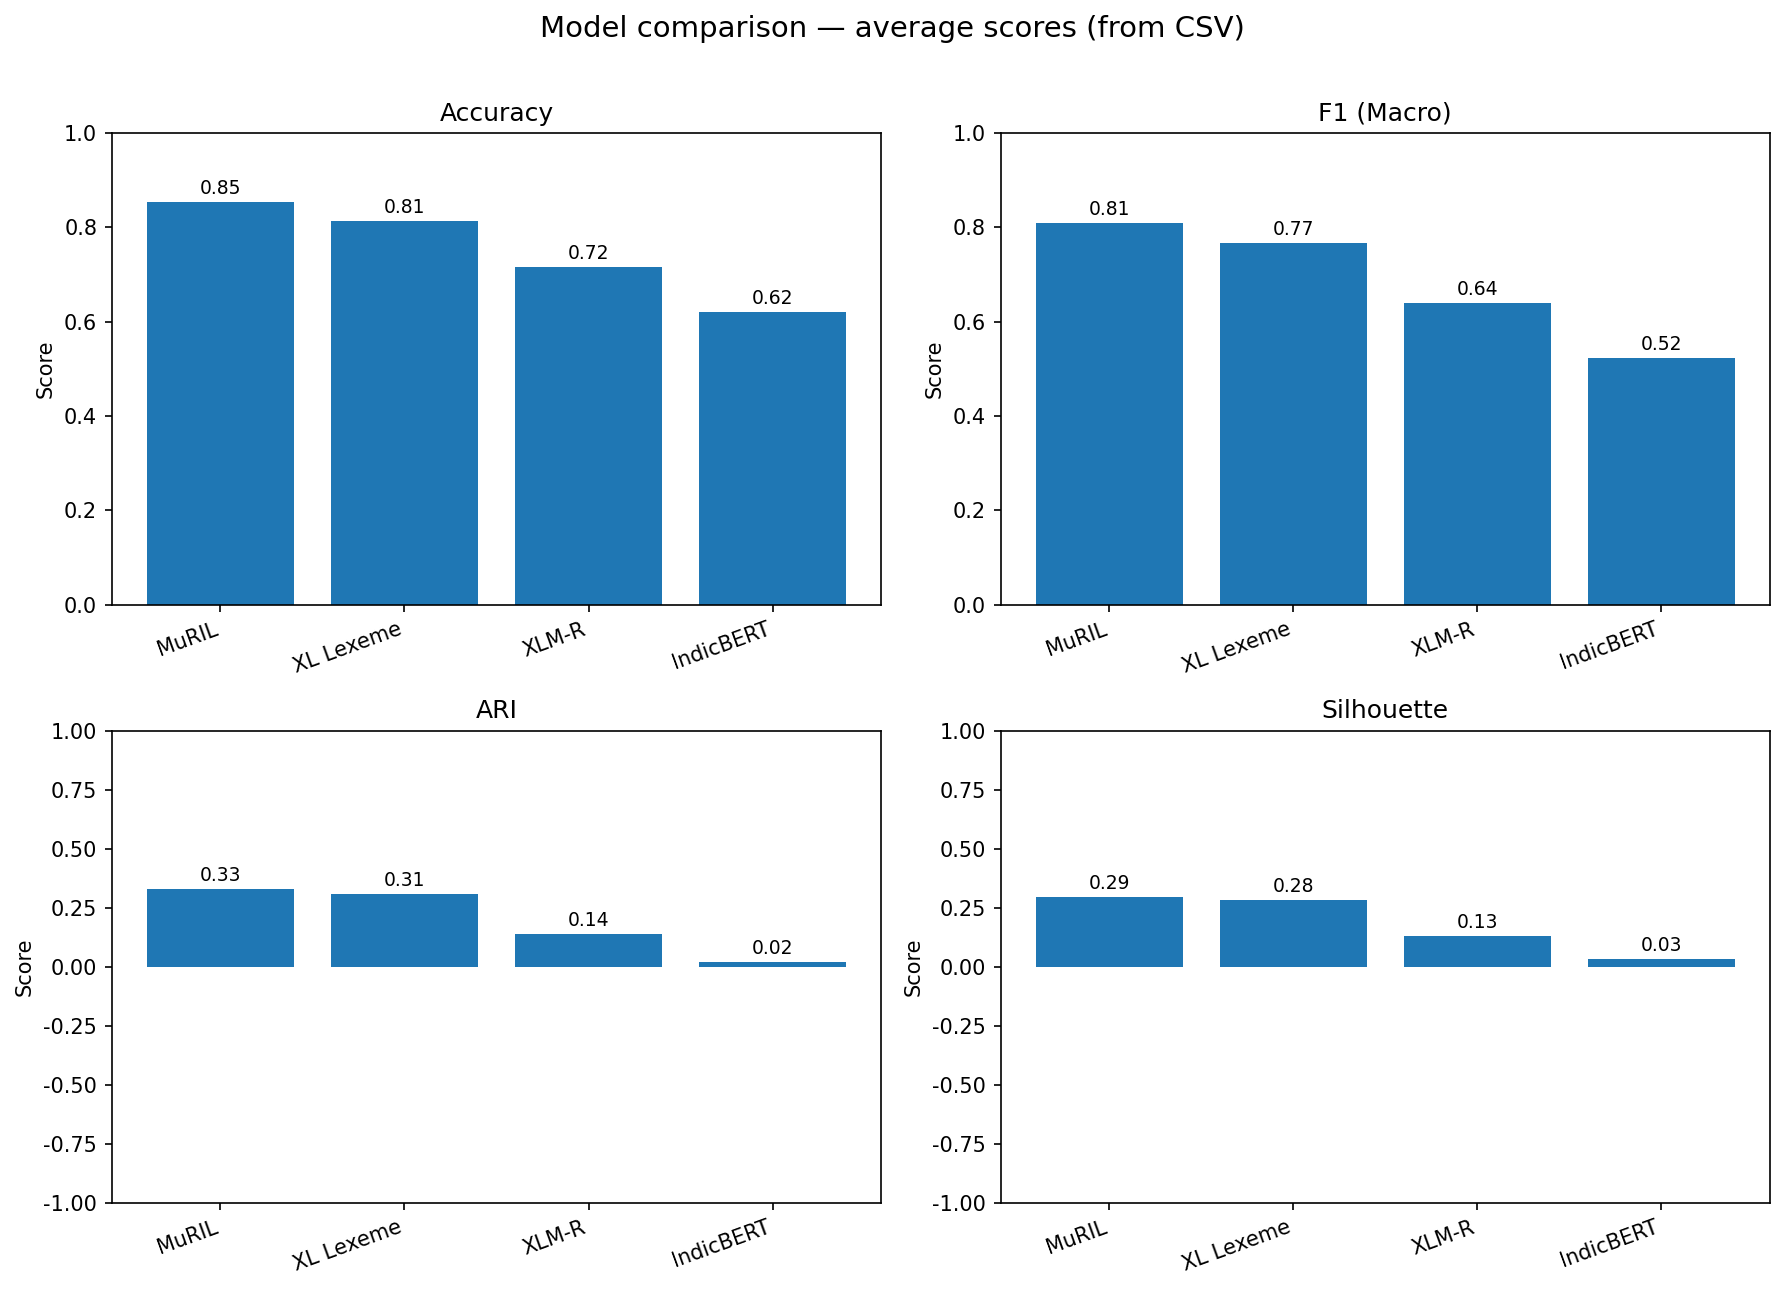

Saved: /content/drive/MyDrive/kannada/model_metric_comparison_20250814-200352/model_comparison_2x2.png


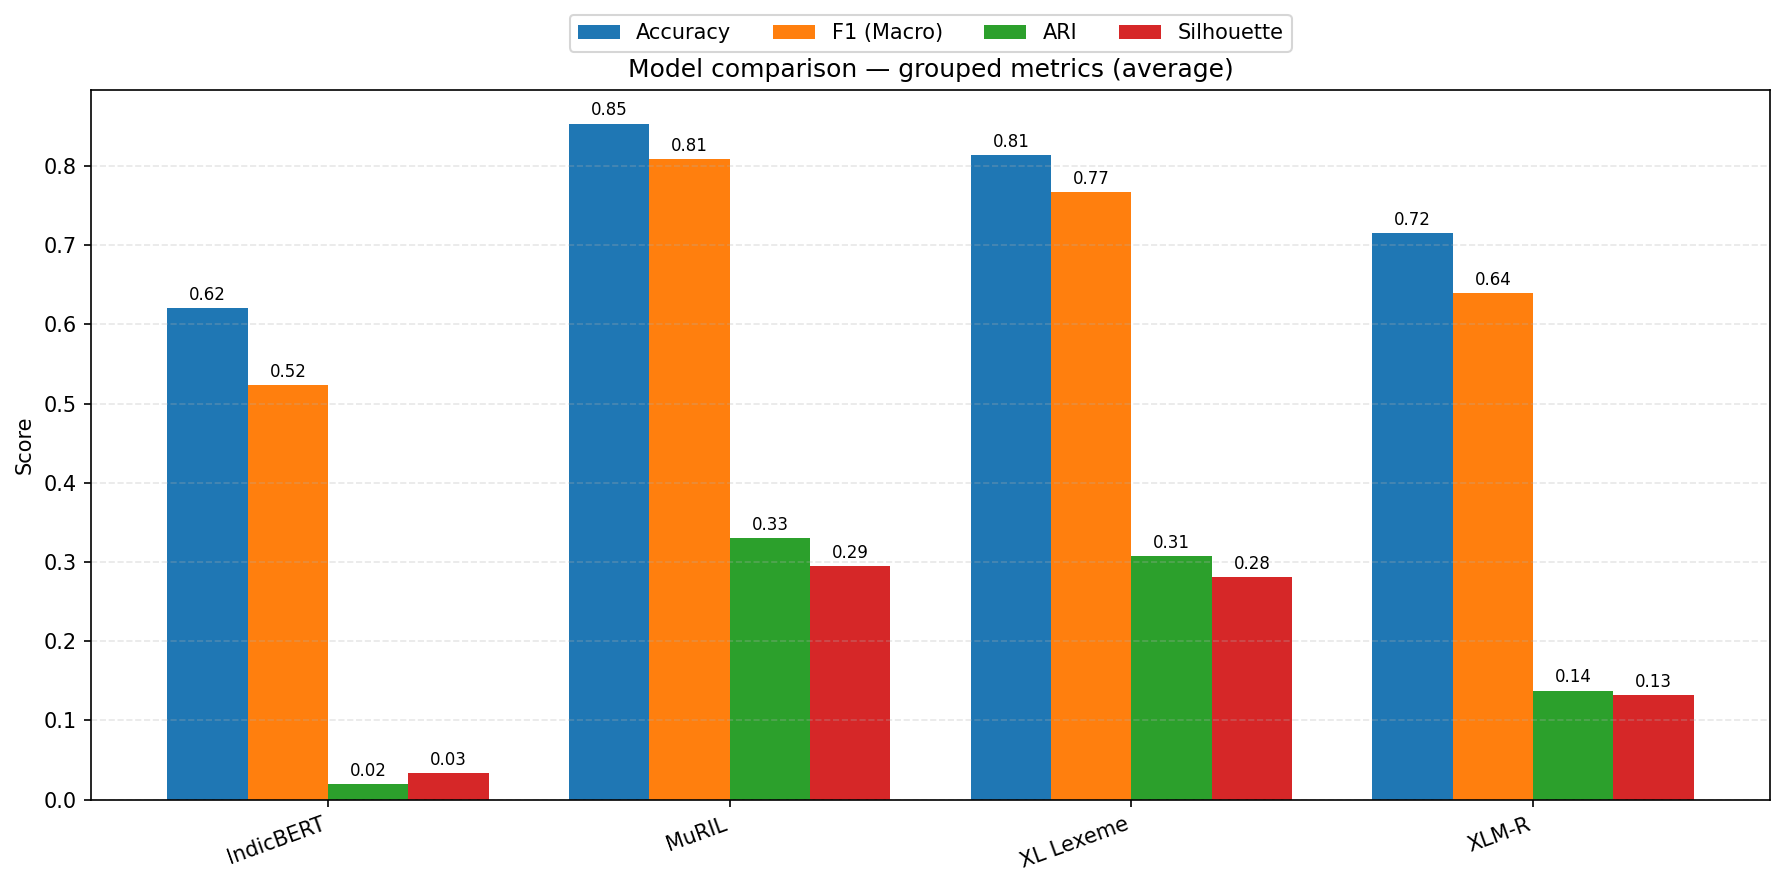

Saved: /content/drive/MyDrive/kannada/model_metric_comparison_20250814-200352/model_comparison_grouped.png
Saved averages CSV: /content/drive/MyDrive/kannada/model_metric_comparison_20250814-200352/per_model_averages.csv


In [ ]:
# =========================================
# Compare models from scores CSV (Colab)
# =========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- EDIT this path to add CSV ----
# e.g., "/content/drive/MyDrive/kannada_comparison_output_YYYYMMDD-HHMMSS/umap_scores_word_model.csv"
SCORES_CSV = "/content/drive/MyDrive/kannada/umap_scores_word_model.csv"

timestamp = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR   = f"/content/drive/MyDrive/kannada/model_metric_comparison_{timestamp}"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving plots to:", OUT_DIR)

# ---- Load & sanity checks ----
df = pd.read_csv(SCORES_CSV)
needed = {"model","accuracy","f1_macro","ari","silhouette"}
missing = needed - set(df.columns.str.lower())
# map case-insensitively if needed
rename_map = {c: c.lower() for c in df.columns}
df = df.rename(columns=rename_map)
if missing:
    raise ValueError(f"CSV must contain columns: {sorted(list(needed))}. Missing: {sorted(list(missing))}")

# ---- Compute per-model averages (skip NaNs) ----
avg = (
    df.groupby("model", as_index=False)
      .agg({
          "accuracy":"mean",
          "f1_macro":"mean",
          "ari":"mean",
          "silhouette":"mean"
      })
)
# Round for display
avg_rounded = avg.copy()
for c in ["accuracy","f1_macro","ari","silhouette"]:
    avg_rounded[c] = avg_rounded[c].round(4)

print("Per-model averages:")
print(avg_rounded)

# ---- Helper to add value labels on bars ----
def add_bar_labels(ax, fmt="{:.2f}"):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x()+p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=9, rotation=0, xytext=(0,2),
                    textcoords="offset points")

# =========================================
# Figure 1: 2×2 grid (Acc, F1, ARI, Silhouette)
# =========================================
metrics = [
    ("accuracy",   "Accuracy",   0.0, 1.0),
    ("f1_macro",   "F1 (Macro)", 0.0, 1.0),
    ("ari",        "ARI",       -1.0, 1.0),
    ("silhouette", "Silhouette",-1.0, 1.0),
]
fig, axes = plt.subplots(2, 2, figsize=(12, 9), dpi=150)
axes = axes.ravel()

for ax, (col, title, ymin, ymax) in zip(axes, metrics):
    # sort bars by metric desc
    plot_df = avg.sort_values(col, ascending=False)
    ax.bar(plot_df["model"], plot_df[col])
    ax.set_title(title)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel("Score")
    ax.set_xticklabels(plot_df["model"], rotation=20, ha="right")
    add_bar_labels(ax)

plt.suptitle("Model comparison — average scores (from CSV)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
grid_path = os.path.join(OUT_DIR, "model_comparison_2x2.png")
plt.savefig(grid_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", grid_path)

# =========================================
# Figure 2: Single grouped bar chart
# =========================================
mnames  = avg["model"].tolist()
x = np.arange(len(mnames))
w = 0.2

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

bars = []
bars.append(ax.bar(x - 1.5*w, avg["accuracy"],   width=w, label="Accuracy"))
bars.append(ax.bar(x - 0.5*w, avg["f1_macro"],   width=w, label="F1 (Macro)"))
bars.append(ax.bar(x + 0.5*w, avg["ari"],        width=w, label="ARI"))
bars.append(ax.bar(x + 1.5*w, avg["silhouette"], width=w, label="Silhouette"))

ax.set_xticks(x)
ax.set_xticklabels(mnames, rotation=20, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model comparison — grouped metrics (average)")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.12))
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Add labels on top of bars
for group in bars:
    for p in group:
        h = p.get_height()
        ax.annotate(f"{h:.2f}",
                    (p.get_x()+p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=8, xytext=(0,2),
                    textcoords="offset points")

group_path = os.path.join(OUT_DIR, "model_comparison_grouped.png")
plt.tight_layout()
plt.savefig(group_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", group_path)

# =========================================
# Also save the averages table for reference
# =========================================
avg_csv = os.path.join(OUT_DIR, "per_model_averages.csv")
avg_rounded.to_csv(avg_csv, index=False)
print("Saved averages CSV:", avg_csv)
